# Fine tuning classification with OpenAI

We will fine-tune an ada classifier the number of stars a reviewer will be given an item

In [7]:
import pandas as pd
import openai 
import os
from datasets import load_dataset
import random
import math
import keyring
import warnings
from openai_finetune_tools import *
warnings.filterwarnings('ignore')

os.environ['OPENAI_API_KEY'] = keyring.get_password('openai', 'key_for_windows')

random.seed(42)
# dataset = load_dataset("amazon_reviews_multi", "all_languages")       # deprecated

In [8]:
# convert training dataset into dataframe
training_df = pd.read_csv('./data/amzon_reviews_multi/train.csv', index_col=0)
training_df.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,de_0203609,product_de_0865382,reviewer_de_0267719,1,Armband ist leider nach 1 Jahr kaputt gegangen,Leider nach 1 Jahr kaputt,de,sports
1,de_0559494,product_de_0678997,reviewer_de_0783625,1,In der Lieferung war nur Ein Akku!,EINS statt ZWEI Akkus!!!,de,home_improvement
2,de_0238777,product_de_0372235,reviewer_de_0911426,1,"Ein Stern, weil gar keine geht nicht. Es hande...",Achtung Abzocke,de,drugstore
3,de_0477884,product_de_0719501,reviewer_de_0836478,1,"Dachte, das wären einfach etwas festere Binden...",Zu viel des Guten,de,drugstore
4,de_0270868,product_de_0022613,reviewer_de_0736276,1,Meine Kinder haben kaum damit gespielt und nac...,Qualität sehr schlecht,de,toy


In [9]:
test_df = pd.read_csv('./data/amzon_reviews_multi/test.csv', index_col=0)
val_df = pd.read_csv('./data/amzon_reviews_multi/validation.csv', index_col=0)
val_df.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,de_0591095,product_de_0301773,reviewer_de_0787123,1,Das Produkt kam bis heute nicht bei mir an. Ic...,Produkte NICHT geliefert,de,toy
1,de_0987834,product_de_0720578,reviewer_de_0983846,1,"Gebrauchte Spinner, teilzerlegt und teilweise ...","Gebrauchtware, ekelhaft",de,toy
2,de_0978206,product_de_0499114,reviewer_de_0238704,1,Bei beiden Bestellungen war jeweils eine Glühb...,Sehr schlechte Qualität,de,home
3,de_0407600,product_de_0648552,reviewer_de_0102048,1,Sofort zurückgeschickt,Der letzte Dreck,de,furniture
4,de_0453469,product_de_0900029,reviewer_de_0862313,1,wie man auf den Fotos erkennen kann ist das Gl...,"passform schlecht, Haftung schlecht - Finger weg",de,wireless


In [10]:
training_df[['review_title', 'review_body', 'stars']].sample(5)

,review_title,review_body,stars
409871,Malo como todos,Pues como las otras 3 marcas que ya he probado...,1
747330,+1,Bon rapport qualité/prix.,4
655582,bof,"Je ne suis pas très satisfait, mais sans doute...",2
322815,Useful lightning to hdmi adapter!,I love this mini handy converter. It's small a...,4
427329,"No puedo opinar ,no me llegó",No lo he recibido !!!!,1


In [11]:
english_training_df = training_df[training_df['language'] == 'en']
english_val_df = val_df[training_df['language'] == 'en']

# Star prediction (sentiment)

## Data Preparation (old version)

In [6]:
'312'               # '1' is a token
'I am number 1'     # '1' is a token

'I am number 1'

In [13]:
## old version jsonl

english_training_df['prompt'] = english_training_df['review_title'] + '\n\n' + english_training_df['review_body'] + '\n\n###\n\n'
english_val_df['prompt'] = english_val_df['review_title'] + '\n\n' + english_val_df['review_body'] + '\n\n###\n\n'

english_training_df['completion'] = ' ' + english_training_df['stars'].astype(str)      # for sentiment
english_val_df['completion'] = ' ' + english_val_df['stars'].astype(str)    # for sentiment

# drop duplicates
english_training_df.sample(
    len(english_training_df)
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "amazon-english-val-sentiment-random.jsonl", orient='records', lines=True
)

english_val_df.sample(
    len(english_val_df)
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "amaxon-english-full-sentiment-random.jsonl", orient='records', lines=True
)

In [14]:
print(english_training_df['prompt'].iloc[0])

I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review ...

Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing this. So, I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review of part of a chair I never got to sit in. I will go so far as to include a picture of what their injection molding and quality assurance process missed though. I will be hesitant to buy again. It makes me wonder if there aren't missing structures and supports that don't impede the assembly process.

###




In [15]:
english_training_df['stars'].iloc[0]

1

<Axes: xlabel='stars'>

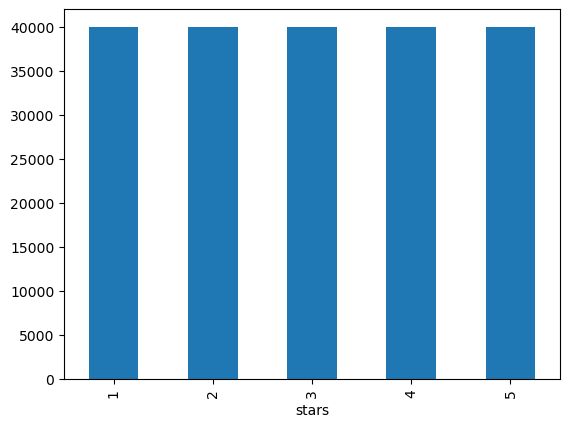

In [20]:
english_training_df['stars'].value_counts().plot(kind='bar')

## Data Preparation (new version)

In [16]:
english_training_df

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,prompt,completion
200000,en_0964290,product_en_0740675,reviewer_en_0342986,1,Arrived broken. Manufacturer defect. Two of th...,I'll spend twice the amount of time boxing up ...,en,furniture,I'll spend twice the amount of time boxing up ...,1
200001,en_0690095,product_en_0440378,reviewer_en_0133349,1,the cabinet dot were all detached from backing...,Not use able,en,home_improvement,Not use able\n\nthe cabinet dot were all detac...,1
200002,en_0311558,product_en_0399702,reviewer_en_0152034,1,I received my first order of this product and ...,The product is junk.,en,home,The product is junk.\n\nI received my first or...,1
200003,en_0044972,product_en_0444063,reviewer_en_0656967,1,This product is a piece of shit. Do not buy. D...,Fucking waste of money,en,wireless,Fucking waste of money\n\nThis product is a pi...,1
200004,en_0784379,product_en_0139353,reviewer_en_0757638,1,went through 3 in one day doesn't fit correct ...,bubble,en,pc,bubble\n\nwent through 3 in one day doesn't fi...,1
...,...,...,...,...,...,...,...,...,...,...
399995,en_0046316,product_en_0980158,reviewer_en_0629807,5,"Cute slippers, my MIL loved them.",Nice and fit as advertised,en,shoes,"Nice and fit as advertised\n\nCute slippers, m...",5
399996,en_0956024,product_en_0954574,reviewer_en_0459072,5,My 6 year old likes this and keeps him engaged...,good to keep the kids engaged,en,toy,good to keep the kids engaged\n\nMy 6 year old...,5
399997,en_0589358,product_en_0402982,reviewer_en_0199163,5,Replaced my battery with it. Works like new.,This works,en,wireless,This works\n\nReplaced my battery with it. Wor...,5
399998,en_0970602,product_en_0873374,reviewer_en_0590563,5,"I like them, holding up well.",Well made.,en,industrial_supplies,"Well made.\n\nI like them, holding up well.\n\...",5


In [ ]:
prompt_sys = ""